In [1]:
from tvb.simulator.lab import *
import numpy as np, matplotlib.pyplot as plt
from tvb.datatypes.connectivity import Connectivity

/opt/anaconda3/envs/tvb_env/lib/python3.10/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [3]:
conn = Connectivity.from_file("connectivity_76.zip")
conn.configure()
N = conn.number_of_regions 

2025-05-19 11:52:09,522 - ERROR - tvb.basic.readers - Could not import tvb_data Python module for default data-set!
Traceback (most recent call last):
  File "/opt/anaconda3/envs/tvb_env/lib/python3.10/site-packages/tvb/basic/readers.py", line 222, in try_get_absolute_path
    module_import = importlib.import_module(relative_module)
  File "/opt/anaconda3/envs/tvb_env/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 992, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1004, in _find_and_load_unlo

In [5]:
print(conn.number_of_regions)

76


In [7]:
conn.configure()
print("Connectivity loaded with", conn.number_of_regions, "regions.")

Connectivity loaded with 76 regions.


In [9]:
wc = models.WilsonCowan(
    c_ee=np.array([20.0]),           
    c_ei=np.array([12.0]),
    c_ie=np.array([18.0]),
    c_ii=np.array([3.0]),
    P   =np.array([0.45]),           
    tau_e=np.array([10.0]),
    tau_i=np.array([25.0]),
)

In [11]:
cpl   = coupling.Linear(a=np.array([0.03]))          
heun  = integrators.HeunDeterministic(dt=0.1)
heun.noise = noise.Additive(nsig=np.array([0.02, 0.02]))

In [13]:
ic = np.zeros((1, 2, N, 1))
ic[0,0,:] = 0.4        
ic[0,1,:] = 0.1

In [15]:
raw_mon  = monitors.Raw()      
bold_mon = monitors.Bold(period=2000.0)              

sim = simulator.Simulator(model=wc, connectivity=conn,
                          coupling=cpl, integrator=heun,
                          monitors=[raw_mon, bold_mon])
sim.simulation_length = 600000.0  
sim.initial_conditions = ic
sim.configure()

In [17]:
(raw_t, raw_dat), (bold_t, bold_dat) = sim.run()

2025-05-19 11:52:13,694 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


In [19]:
sim.configure()
raw_result = sim.run()

2025-05-19 12:05:02,694 - WARNING - tvb.simulator.integrators - random_state supplied for non-stochastic integration


In [21]:
raw_output = raw_result[0]
time, data = raw_output
data = np.squeeze(data)
print('Time shape:', time.shape)
print('Data shape:', data.shape)

Time shape: (6000000,)
Data shape: (6000000, 76)


In [23]:
bold = np.squeeze(bold_dat[:, 0, :, 0])
transient_cutoff = 50  
bold_trimmed = bold[transient_cutoff:]

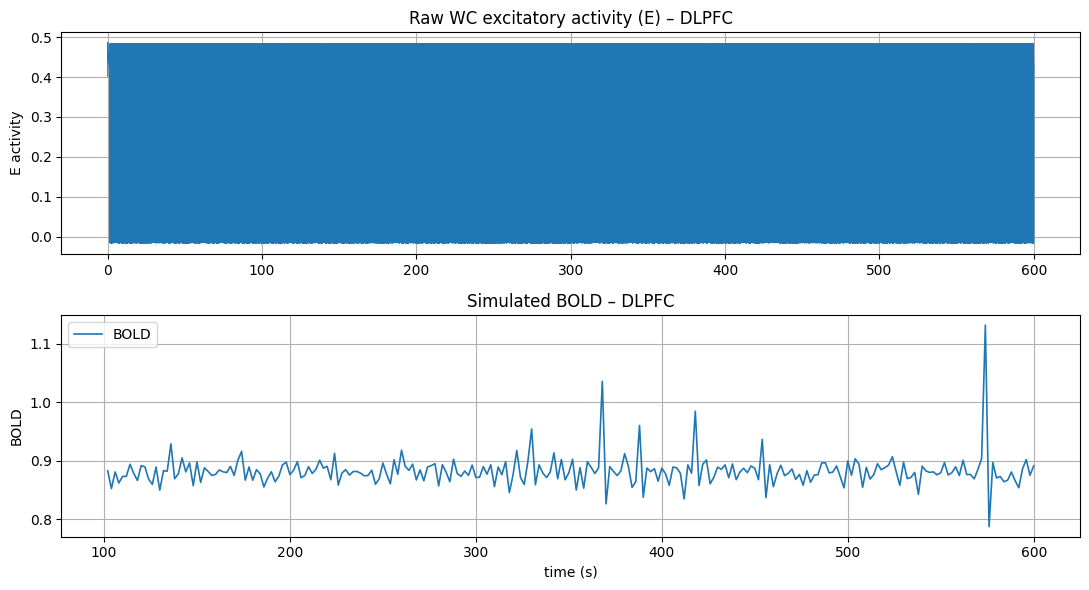

In [25]:
dlpfc = 18

fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=False)

ax[0].plot(raw_t / 1000, raw_dat[:, 0, dlpfc, 0], lw=0.8)
ax[0].set(title="Raw WC excitatory activity (E) – DLPFC", ylabel="E activity")
ax[0].grid(True)

trimmed_bold = bold_dat[transient_cutoff:, 0, dlpfc, 0]
trimmed_time = bold_t[transient_cutoff:] / 1000  

ax[1].plot(trimmed_time, trimmed_bold, lw=1.2, label="BOLD")
ax[1].set(title="Simulated BOLD – DLPFC", xlabel="time (s)", ylabel="BOLD")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.savefig("figures/healthy_signals.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
print("bold_trimmed shape:", bold_trimmed.shape)

bold_trimmed shape: (250, 76)


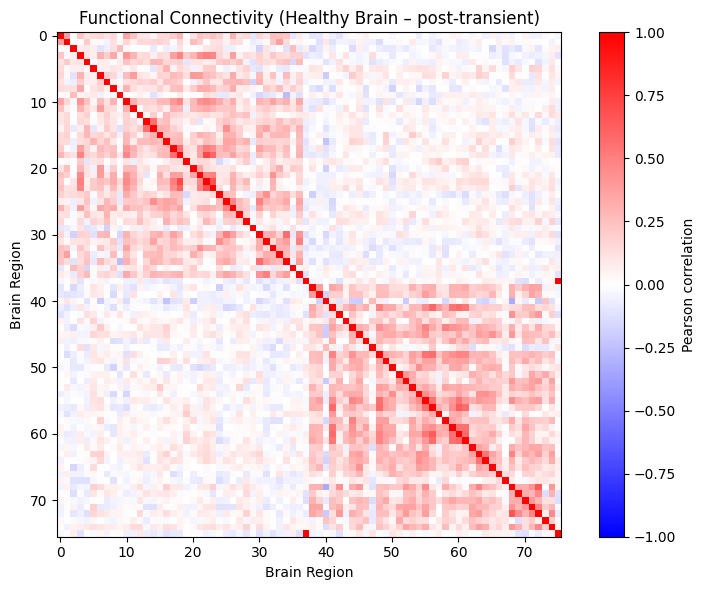

In [29]:
import numpy as np
import matplotlib.pyplot as plt

fc_matrix = np.corrcoef(bold_trimmed.T)

plt.figure(figsize=(8, 6))
plt.imshow(fc_matrix, cmap='bwr', vmin=-1, vmax=1)
plt.title("Functional Connectivity (Healthy Brain – post-transient)")
plt.xlabel("Brain Region")
plt.ylabel("Brain Region")
plt.colorbar(label="Pearson correlation")
plt.tight_layout()
plt.show()

In [31]:
np.save("fc_matrix_healthy.npy", fc_matrix)

In [35]:
print(data.shape)

(6000000, 76)


In [37]:
import matplotlib.pyplot as plt
import numpy as np

In [39]:
raw_output = raw_result[0]
time, data = raw_output
data = np.squeeze(data)

In [41]:
time = np.arange(0, 6000000) * 0.1 / 1000

In [43]:
selected_regions = [18, 23, 0, 51, 74]

In [61]:
start_time = 100
end_time = 105

In [63]:
start_idx = (time >= start_time).argmax()
end_idx = (time >= end_time).argmax()

In [65]:
print("data shape:", data.shape)  

data shape: (6000000, 76)


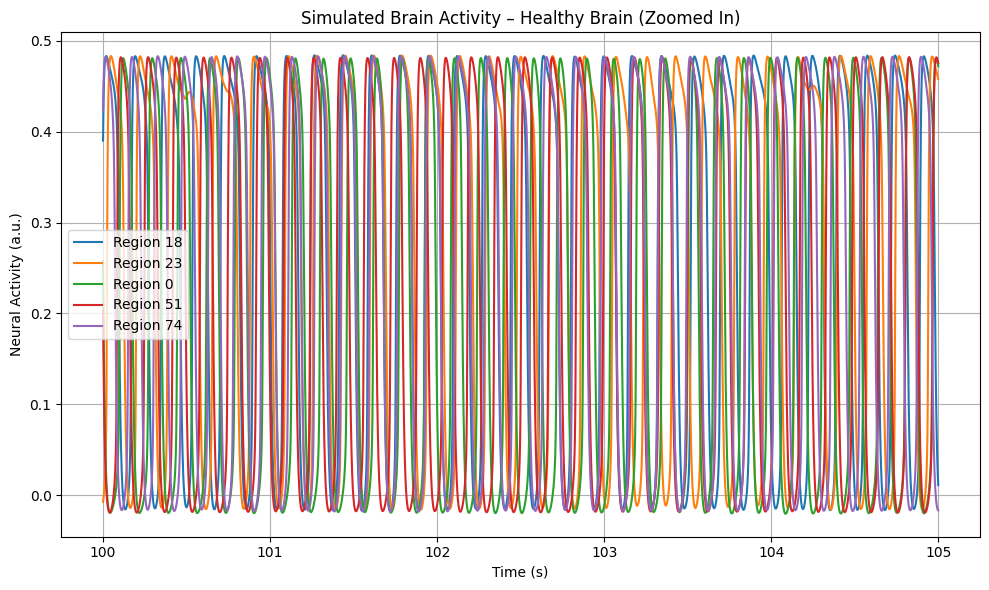

In [67]:
plt.figure(figsize=(10, 6))
for region in selected_regions:
    plt.plot(time[start_idx:end_idx], data[start_idx:end_idx, region], label=f'Region {region}')

plt.title("Simulated Brain Activity – Healthy Brain (Zoomed In)")
plt.xlabel("Time (s)")
plt.ylabel("Neural Activity (a.u.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures/healthy_zoomed_regions.png", dpi=300, bbox_inches='tight')
plt.show()

In [69]:
import numpy as np
import pickle

In [71]:
np.save("raw_healthy.npy", raw_dat)
np.save("bold_healthy.npy", bold_dat)